In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from itertools import product
import time

In [2]:
G = 1000
N = 100
random_state = 1

p_c = 0.1
p_m = 0.3
prob = p_c,p_m

queens = 64

c = 0.3
rank_type = 'exponential'

In [3]:
class Individuo:
    def __init__(self,n):
        self.x = np.zeros(n, dtype='int') ## n, dtype='int'
        self.f = 0.0
    def __lt__(self, ind):
        return self.f < ind.f

In [4]:
def InitializePopulation(P):
    n = P[0].x.size
    for I in P:
        I.x[:] = np.random.permutation(n)

In [5]:
def f(x):
    """Calcula el número de jaques en diagonal entre reinas dado un array de posiciones."""
    n = len(x)
    conflicts = 0

    # Revisar conflictos en diagonales
    for i in range(n):
        for j in range(i + 1, n):
            if abs(i - j) == abs(x[i] - x[j]):  # Mismo valor absoluto en la diferencia (diagonal)
                conflicts += 1

    return conflicts  # Se devuelve el número de conflictos (positivo)

def evaluate(I, f):           
    """Evalúa el fitness de un individuo y lo guarda en I.f"""
    I.f = f(I.x)  # Se pasa I.x como array a la función fitness

In [6]:
def copia(I1, I2):
    np.copyto(I1.x, I2.x)
    I1.f = I2.f   

In [7]:
def calculate_cumulative_probabilities(cumulative_probabilities, P, c, rank_type):
    """
    Calcula las probabilidades acumuladas para la selección de ranking exponencial.

    Parámetros:
    - cumulative_probabilities (numpy.ndarray): Vector donde se almacenarán las probabilidades acumuladas.
    - P (list): Lista de individuos de la población actual, ordenados de mejor a peor.
    - c (float): Parámetro de control para la selección exponencial. Debe ser mayor que 1.
    - rank_type (str): Tipo de ranking a usar. Solo soporta "exponential" en esta versión.

    Funcionamiento:
    - Se asignan probabilidades decrecientes de manera exponencial a los individuos.
    - La probabilidad de selección de un individuo depende de su ranking en la población.
    """

    N = len(P)  # Tamaño de la población
    
    if rank_type == 'exponential':
        den = c**N - 1  # Normalización para que la suma total sea 1
        cumulative_probabilities[0] = (c - 1) / den  # Probabilidad del primer individuo

        for i in range(1, N):
            cumulative_probabilities[i] = cumulative_probabilities[i - 1] + ((c - 1) * c**i) / den


In [8]:
def selection(P,cumulative_probabilities):
    r = np.random.random()
    i = 0
    while (cumulative_probabilities[i]<r):
        i += 1 
    return P[i]

In [9]:
def crossover_pmx(parent1, parent2):
    n = len(parent1.x)
    cx1, cx2 = sorted(np.random.choice(n, 2, replace=False))
    
    child1, child2 = Individuo(n), Individuo(n)
    child1.x[:], child2.x[:] = -1, -1

    child1.x[cx1:cx2+1] = parent1.x[cx1:cx2+1]
    child2.x[cx1:cx2+1] = parent2.x[cx1:cx2+1]

    def completar_hijo(child, parent, cx1, cx2):
        mapping = {parent.x[i]: child.x[i] for i in range(cx1, cx2+1)}
        assigned = set(child.x[cx1:cx2+1])  # Evitar valores duplicados

        for i in range(n):
            if i < cx1 or i > cx2:
                value = parent.x[i]
                while value in mapping and mapping[value] != -1:
                    value = mapping[value]
                if value in assigned:
                    value = next(v for v in range(n) if v not in assigned)
                child.x[i] = value
                assigned.add(value)

        return child

    child1 = completar_hijo(child1, parent2, cx1, cx2)
    child2 = completar_hijo(child2, parent1, cx1, cx2)

    return child1, child2

In [10]:
def mutation_swap(ind, mutation_prob):
    if np.random.random() < mutation_prob:
        i, j = np.random.choice(len(ind.x), 2, replace=False)
        ind.x[i], ind.x[j] = ind.x[j], ind.x[i]
    ind.f = f(ind.x)  # Recalcular fitness siempre
    return ind

In [36]:
def IniciaProgreso(G, best_fitness_inicial):
    """
    Inicializa la barra de progreso para el Algoritmo Evolutivo.
    
    Parámetros:
    - G (int): Número máximo de generaciones.
    - best_fitness_inicial (int): Fitness del mejor individuo en la población inicial.

    Retorna:
    - best_outputs (list): Historial del mejor fitness en cada generación.
    - progression_bar (tqdm object): Barra de progreso.
    """
    best_outputs = [0] * (G + 1)  # Inicializar con valores vacíos
    best_outputs[0] = best_fitness_inicial  # Solo el primer valor es el fitness inicial

    progression_bar = tqdm(total=G, desc="Evolucionando", unit="gen", leave=False)
    return best_outputs, progression_bar

def ActualizaProgreso(P, gen, best_outputs, progression_bar):
    """
    Actualiza la barra de progreso con el mejor fitness actual.

    Parámetros:
    - P (list): Población actual.
    - gen (int): Número de generación actual.
    - best_outputs (list): Historial de fitness.
    - progression_bar (tqdm object): Barra de progreso.
    """
    best_fitness = min(P, key=lambda ind: ind.f).f  # Mejor fitness en la población actual
    best_outputs[gen] = best_fitness  # Guardamos el mejor fitness
    progression_bar.set_postfix(fitness=best_fitness)  # Actualizar la barra con el mejor fitness
    progression_bar.update(1)  # Avanzar la barra en una unidad

In [12]:
def plot_n_queens(solution):
    """Dibuja el tablero de ajedrez con las reinas correctamente alineadas."""
    N = len(solution)
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Dibujar el tablero de ajedrez
    for i in range(N):
        for j in range(N):
            color = "white" if (i + j) % 2 == 0 else "gray"
            ax.add_patch(plt.Rectangle((j, N - i - 1), 1, 1, color=color))

    # Dibujar líneas de la cuadrícula
    ax.set_xticks(np.arange(N+1))
    ax.set_yticks(np.arange(N+1))
    ax.grid(which="major", color="black", linestyle='-', linewidth=1)
    ax.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)

    # Dibujar las reinas en el centro exacto de cada celda
    for row, col in enumerate(solution):
        ax.text(col + 0.5, N - row - 0.5, '♛', fontsize=20, ha='center', va='center', color="red")

    ax.set_xlim(0, N)
    ax.set_ylim(0, N)
    plt.title(f"Solución para {N} reinas")
    plt.show()

In [27]:
def EA(G, N, prob, rank_type, random_state, show_progress=True):
    """
    Algoritmo Evolutivo con opción para desactivar la barra de progreso.

    Parámetros:
    - G (int): Número máximo de generaciones.
    - N (int): Tamaño de la población.
    - prob (tuple): (probabilidad de cruce, probabilidad de mutación).
    - rank_type (str): Tipo de ranking usado en la selección.
    - random_state (int): Semilla aleatoria.
    - show_progress (bool): Si True, muestra la barra de progreso; si False, no la muestra.

    Retorna:
    - best_outputs (list): Historial del mejor fitness por generación.
    - best_fitness (float): Mejor fitness encontrado.
    - best_solution (list): Representación de la mejor solución.
    - num_generations (int): Número de generaciones necesarias para encontrar la mejor solución.
    """

    np.random.seed(random_state)
    prob_cross, prob_mutation = prob

    assert G >= 1, "El número de generaciones debe ser mayor o igual que 1."
    assert N >= 2 and not N % 2, "El tamaño de la población debe ser par y mayor que 1."

    cumulative_probabilities = np.zeros(N)

    # Crear y inicializar población
    P = [Individuo(queens) for _ in range(N)]
    InitializePopulation(P)

    # Evaluar población inicial
    for I in P:
        evaluate(I, f)

    # Ordenar la población para selección por ranking
    P = sorted(P, key=lambda ind: ind.f)

    best_individuo = P[0]

    # Inicializar barra de progreso solo si show_progress es True
    best_outputs, progression_bar = (IniciaProgreso(G, best_fitness_inicial = best_individuo.f) if show_progress else ([best_individuo.f] * (G + 1), None))

    for gen in range(1, G + 1):
        calculate_cumulative_probabilities(cumulative_probabilities, P, c, rank_type)

        Q = []
        i = 0
        while i < N:
            parent1 = selection(P, cumulative_probabilities)
            parent2 = selection(P, cumulative_probabilities)
            if np.random.random() < prob_cross:
                child1, child2 = crossover_pmx(parent1, parent2)
            else:
                child1, child2 = Individuo(len(parent1.x)), Individuo(len(parent2.x))
                copia(child1, parent1)
                copia(child2, parent2)

            # Aplicamos mutación con menor probabilidad
            child1 = mutation_swap(child1, mutation_prob=prob_mutation)
            child2 = mutation_swap(child2, mutation_prob=prob_mutation)

            Q.append(child1)
            Q.append(child2)
            i += 2    

        # Evaluar nueva población antes de ordenarla
        for I in Q:
            evaluate(I, f)

        # Sustitución generacional completa (ordenando de menor a mayor, minimizando fitness)
        P = sorted(Q, key=lambda ind: ind.f)

        # Guardar mejor individuo
        if P[0].f < best_individuo.f:
            best_individuo = P[0]

        # Actualizar la barra de progreso solo si está activa
        if show_progress:
            ActualizaProgreso(P, gen, best_outputs, progression_bar)

        # Criterio de terminación (si encontramos una solución válida)
        if best_individuo.f == 0:
            if show_progress:
                progression_bar.set_description(f"✅ Solución encontrada en {gen} generaciones")
                progression_bar.close()
            return best_outputs, best_individuo.f, best_individuo.x, gen

    if show_progress:
        progression_bar.close()
    return best_outputs, best_individuo.f, best_individuo.x, G  # Retornar total de generaciones si no encontró solución

In [28]:
# Definir la grid de hiperparámetros
cross_probs = np.linspace(0.1, 1.0, 10)  # 10 valores en (0.0, 1.0]
mut_probs = np.linspace(0.05, 0.3, 10)  # 10 valores en (0.0, 0.3]

# Crear combinaciones de hiperparámetros
param_grid = list(product(cross_probs, mut_probs))

# Definir número de repeticiones
num_repetitions = 3

In [30]:
def evaluate_hyperparameters(param_grid, num_repetitions, rank_type, G=1000, N=100):
    """
    Ejecuta Grid Search para determinar la mejor combinación de p_c y p_m.

    Parámetros:
    - param_grid: Lista con combinaciones de (p_c, p_m).
    - num_repetitions: Número de veces que se ejecuta cada combinación con semillas distintas.
    - rank_type: Tipo de selección usada (proporcional o ranking exponencial).
    - G: Número de generaciones.
    - N: Tamaño de la población.

    Retorna:
    - best_params: Mejor combinación de (p_c, p_m) encontrada.
    - best_metrics: Métricas asociadas a los mejores hiperparámetros.
    """

    results = []

    with tqdm(total=len(param_grid), desc="Evaluando hiperparámetros", unit="iter") as pbar:
        for p_c, p_m in param_grid:
            fitness_values = []
            generations_needed = []
            success_count = 0  # Contador de ejecuciones exitosas

            for rep in range(num_repetitions):
                random_state = rep  # Usamos diferentes semillas
                prob = (p_c, p_m)

                # Ejecutar el algoritmo evolutivo
                _, best_fitness, _, num_generations = EA(G, N, prob, rank_type, random_state, show_progress=False)

                # Guardar métricas
                fitness_values.append(best_fitness)
                generations_needed.append(num_generations)

                # Contar si encontramos una solución óptima (fitness = 0)
                if best_fitness == 0:
                    success_count += 1

            # Calcular estadísticas de la combinación
            avg_fitness = np.mean(fitness_values)
            std_fitness = np.std(fitness_values)
            avg_generations = np.mean(generations_needed)
            std_generations = np.std(generations_needed)
            success_rate = success_count / num_repetitions  # Proporción de éxito

            results.append((p_c, p_m, avg_fitness, std_fitness, avg_generations, std_generations, success_rate))

            pbar.update(1)  # Avanzar la barra de progreso

    # Convertir resultados en un array estructurado
    results = np.array(results, dtype=[
        ('p_c', float), ('p_m', float),
        ('fitness', float), ('std_fitness', float),
        ('generations', float), ('std_generations', float),
        ('success_rate', float)
    ])

    # Seleccionar la mejor combinación:
    # 🔹 Primero, buscamos la de menor fitness promedio
    best_indices = np.where(results['fitness'] == np.min(results['fitness']))[0]

    if len(best_indices) == 1:
        best_index = best_indices[0]  # Si hay un único mínimo, seleccionamos ese
    else:
        # 🔹 En caso de empate en fitness, elegimos la que requiera menos generaciones promedio
        best_index = best_indices[np.argmin(results['generations'][best_indices])]

    best_params = (results[best_index]['p_c'], results[best_index]['p_m'])

    best_metrics = {
        "fitness_promedio": results[best_index]['fitness'],
        "fitness_std": results[best_index]['std_fitness'],
        "generaciones_promedio": results[best_index]['generations'],
        "generaciones_std": results[best_index]['std_generations'],
        "tasa_exito": results[best_index]['success_rate']
    }

    return best_params, best_metrics

In [ ]:
best_params, best_metrics = evaluate_hyperparameters(param_grid, num_repetitions=3, rank_type=rank_type, G = 500, N = 14)

print(f"🔹 Mejor combinación encontrada: p_c={best_params[0]}, p_m={best_params[1]}")
print()
print('Donde los resultados estadísticos más relevantes fueron:')
print()
print(f"🔹 Fitness promedio: {best_metrics['fitness_promedio']}")
print(f"🔹 Desviación estándar del fitness: {best_metrics['fitness_std']}")
print(f"🔹 Generaciones promedio para convergencia: {best_metrics['generaciones_promedio']}")
print(f"🔹 Desviación estándar de generaciones: {best_metrics['generaciones_std']}")
print(f"🔹 Tasa de éxito: {best_metrics['tasa_exito']}")

Evaluando hiperparámetros: 100%|██████████| 100/100 [32:15<00:00, 19.35s/iter]

🔹 Mejor combinación encontrada: p_c=1.0, p_m=0.2722222222222222
🔹 Fitness promedio: 0.6666666666666666
🔹 Desviación estándar del fitness: 0.4714045207910317
🔹 Generaciones promedio para convergencia: 462.3333333333333
🔹 Desviación estándar de generaciones: 53.268710849386586


In [37]:
def EjecutaEA(nRun, G, N, best_params, rank_type):
    """
    Ejecuta el Algoritmo Evolutivo nRun veces y guarda la evolución del fitness.

    Parámetros:
    - nRun (int): Número de ejecuciones a realizar.
    - G (int): Número de generaciones.
    - N (int): Tamaño de la población.
    - best_params (tuple): (p_c, p_m) de la mejor configuración encontrada.
    - rank_type (str): Tipo de ranking usado en la selección.

    Retorna:
    - best_fitness_by_generations (array): Evolución del fitness en cada ejecución.
    - best_fitness_by_execution (array): Mejor fitness final por ejecución.
    - best_solution_by_execution (array): Mejor solución por ejecución.
    - num_generations_by_execution (array): Número de generaciones necesarias por ejecución.
    """
    
    # Inicialización de arrays
    best_fitness_by_generations = np.zeros((nRun, G + 1))  # Guardar fitness en cada generación
    best_fitness_by_execution = np.zeros(nRun)
    best_solution_by_execution = [None] * nRun
    num_generations_by_execution = np.zeros(nRun)
    
    for i in range(nRun):
        start_time = time.time()
        random_state = i  # Usamos i como semilla para reproducibilidad

        # Ejecutar EA y almacenar resultados
        best_outputs, best_fitness, best_solution, num_generations = EA(G, N, best_params, rank_type, random_state)

        best_fitness_by_generations[i] = best_outputs  # Guardar evolución del fitness
        best_fitness_by_execution[i] = best_fitness
        best_solution_by_execution[i] = best_solution
        num_generations_by_execution[i] = num_generations

        elapsed_time = time.time() - start_time
        print(f"🔹 Run {i+1}/{nRun} completado en {elapsed_time:.2f} segundos - Mejor fitness: {best_fitness}")

    return best_fitness_by_generations, best_fitness_by_execution, best_solution_by_execution, num_generations_by_execution

In [52]:
def graficar_evolucion_fitness_grid(best_fitness_by_generations, titulo):
    """
    Grafica la evolución del fitness en un grid de 5x2, mostrando una gráfica por cada ejecución.

    Parámetros:
    - best_fitness_by_generations (numpy.ndarray): Matriz de tamaño (nRun, G+1) con la evolución del fitness.
    - titulo (str): Título general de la figura.
    """
    nRun = best_fitness_by_generations.shape[0]  # Número de ejecuciones
    fig, axes = plt.subplots(5, 2, figsize=(14, 18))  # Ajustar tamaño para mejor visualización
    fig.suptitle(titulo, fontsize=16)

    for i, ax in enumerate(axes.flat):  # Iterar sobre los 10 subgráficos
        if i < nRun:  # Solo graficamos si hay datos disponibles
            fitness_values = best_fitness_by_generations[i]  # Fitness de la ejecución i
            unique_fitness_values = np.unique(fitness_values)  # Valores únicos del fitness

            # Filtrar solo valores enteros
            unique_fitness_values = unique_fitness_values[unique_fitness_values.astype(int) == unique_fitness_values]

            # Determinar los valores que siempre deben estar presentes
            essential_ticks = [0, 1]
            filtered_unique_values = [val for val in unique_fitness_values if val not in essential_ticks]

            # Seleccionar hasta 8 valores adicionales para evitar solapamientos
            num_extra_ticks = min(7, len(filtered_unique_values))  # Máximo 7 ticks adicionales
            if num_extra_ticks > 0:
                selected_extra_ticks = np.linspace(filtered_unique_values[0], filtered_unique_values[-1], num_extra_ticks)
                selected_extra_ticks = np.round(selected_extra_ticks).astype(int)  # Redondear y convertir a enteros únicos
                selected_extra_ticks = np.unique(selected_extra_ticks)  # Eliminar duplicados
            else:
                selected_extra_ticks = []

            # Combinar los valores esenciales con los seleccionados
            selected_ticks = np.unique(np.concatenate(([0, 1], selected_extra_ticks)))

            ax.plot(fitness_values, label=f"Ejecución {i+1}", color="blue")
            ax.set_xlabel("Generaciones")
            ax.set_ylabel("Mejor Fitness")
            ax.set_title(f"Ejecución {i+1}")
            ax.set_yticks(selected_ticks)  # Establecer solo valores enteros como ticks
            ax.grid()
        else:
            ax.axis("off")  # Ocultar gráficos extra en caso de haber menos de 10 ejecuciones

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Ajustar el layout sin solapar el título
    plt.show()

In [49]:
best_fitness_by_generations_AE2, best_fitness_by_execution_AE2, best_solution_by_execution_AE2, num_generations_by_execution_AE2 = EjecutaEA(nRun=10, G = G, N = N, best_params=best_params, rank_type=rank_type)

🔹 Run 1/10 completado en 13.09 segundos - Mejor fitness: 0


🔹 Run 2/10 completado en 27.27 segundos - Mejor fitness: 0


🔹 Run 3/10 completado en 102.18 segundos - Mejor fitness: 1


🔹 Run 4/10 completado en 32.69 segundos - Mejor fitness: 0


🔹 Run 5/10 completado en 10.77 segundos - Mejor fitness: 0


🔹 Run 6/10 completado en 99.72 segundos - Mejor fitness: 1


🔹 Run 7/10 completado en 18.01 segundos - Mejor fitness: 0


🔹 Run 8/10 completado en 97.79 segundos - Mejor fitness: 1


🔹 Run 9/10 completado en 68.74 segundos - Mejor fitness: 0


🔹 Run 10/10 completado en 52.76 segundos - Mejor fitness: 0


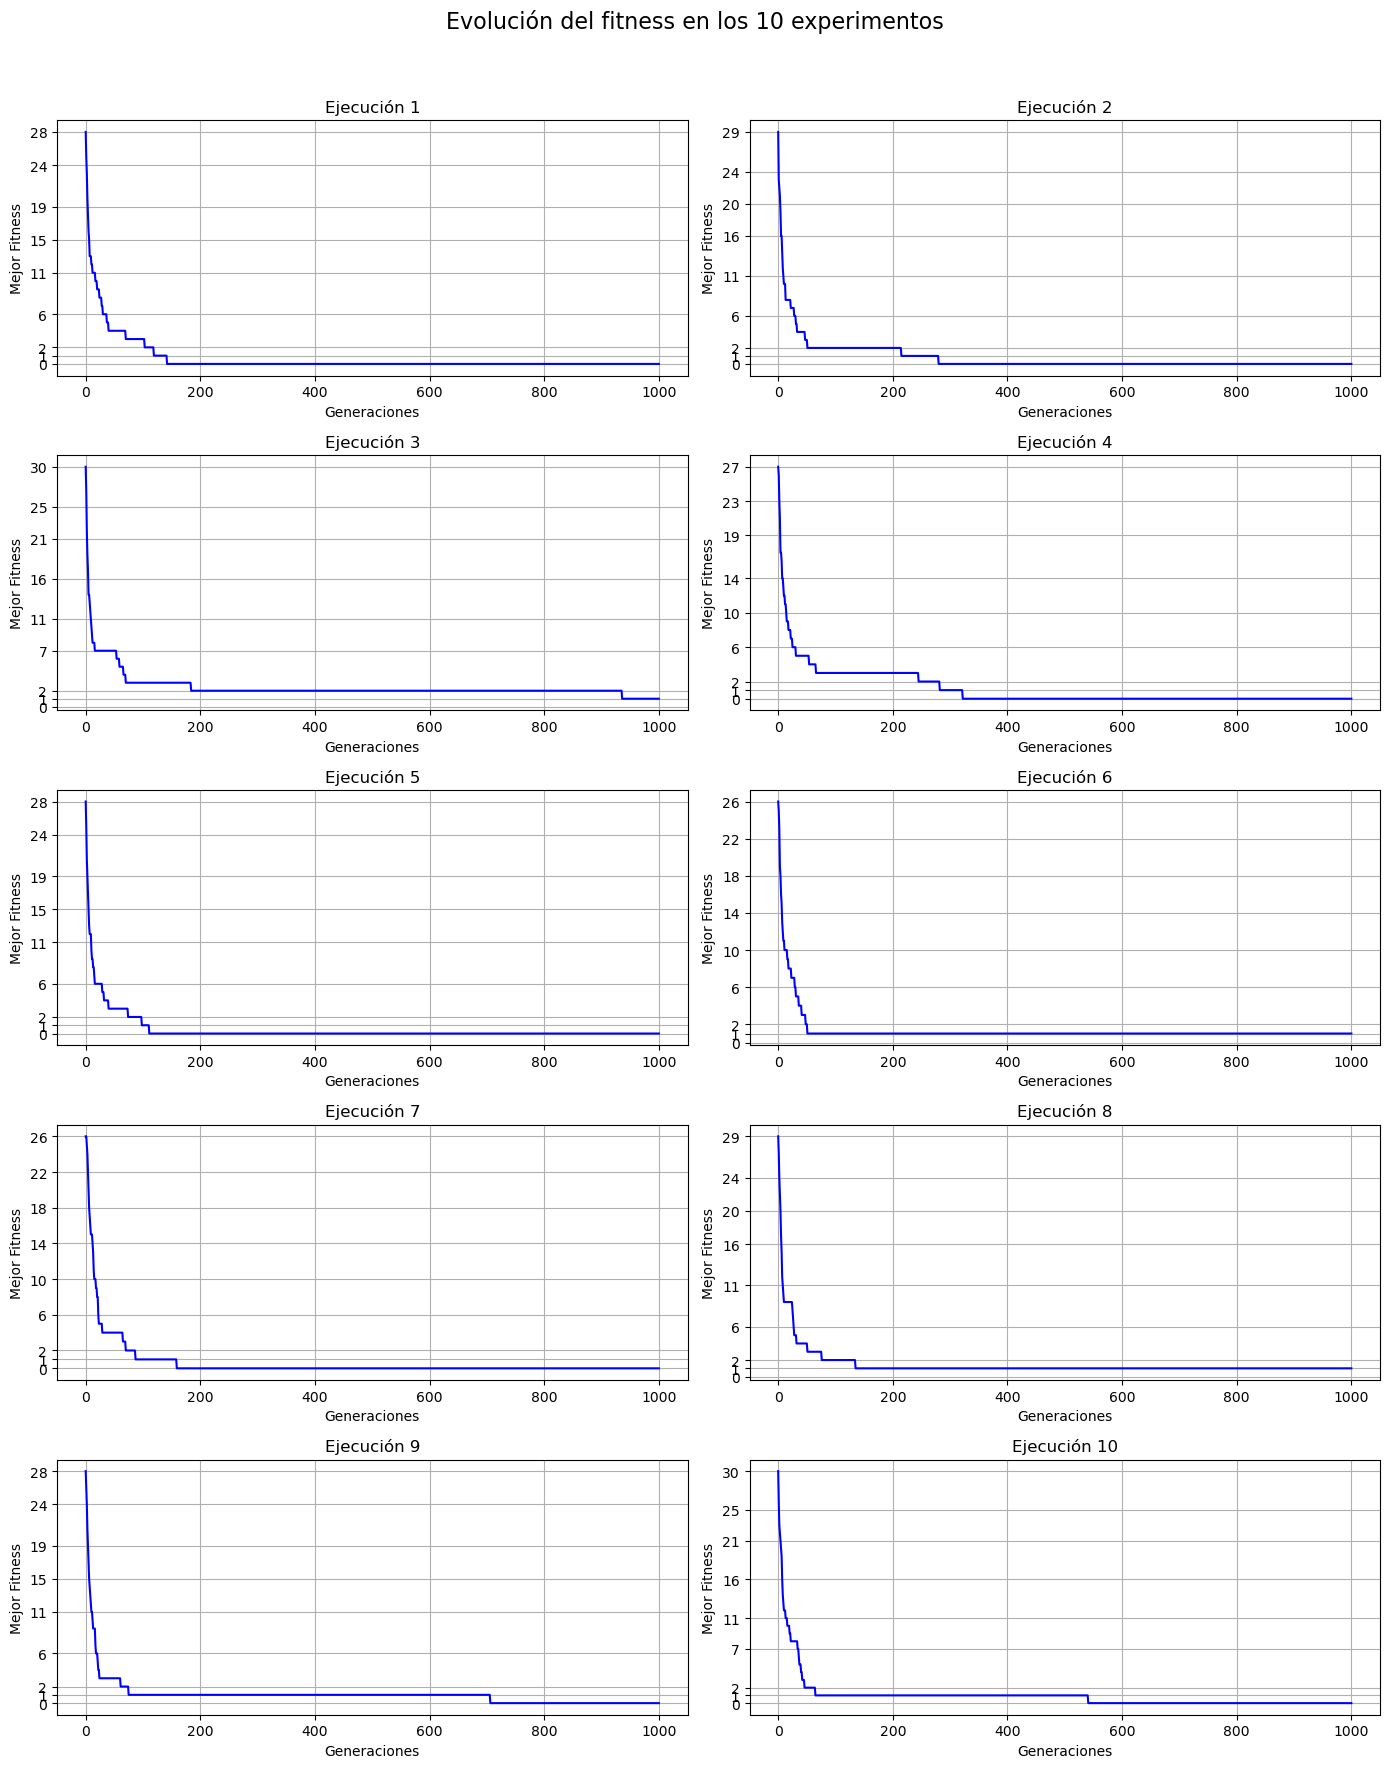

In [53]:
graficar_evolucion_fitness_grid(best_fitness_by_generations=best_fitness_by_generations_AE2, titulo="Evolución del fitness en los 10 experimentos")

In [54]:
# Calcular métricas clave para AE2
fitness_promedio_AE2 = np.mean(best_fitness_by_execution_AE2)  # Fitness promedio
generaciones_promedio_AE2 = np.mean(num_generations_by_execution_AE2)  # Generaciones promedio
tasa_exito_AE2 = np.sum(np.array(best_fitness_by_execution_AE2) == 0) / len(best_fitness_by_execution_AE2)  # Tasa de éxito

# Mostrar resultados en consola
print(f"Fitness Promedio AE2: {fitness_promedio_AE2:.2f}")
print(f"Número de Generaciones Promedio AE2: {generaciones_promedio_AE2:.2f}")
print(f"Tasa de Éxito AE2: {tasa_exito_AE2:.2%}")  # Convertimos a porcentaje

Fitness Promedio AE2: 0.30
Número de Generaciones Promedio AE2: 526.10
Tasa de Éxito AE2: 70.00%


In [ ]:
import pandas as pd
import os

# Nombre del archivo CSV
csv_filename = "num_gen.csv"

# Datos de AE2
num_generations_ae2 = num_generations_by_execution_AE2  # Lista con iteraciones de AE2

# Cargar el archivo si existe
if os.path.exists(csv_filename):
    df_existing = pd.read_csv(csv_filename, index_col=0)  # Cargar sin modificar índice
    df_existing["AE2"] = num_generations_ae2  # Agregar columna AE2
    df_existing.to_csv(csv_filename)  # Guardar de nuevo
    print(f"✅ Resultados de AE2 añadidos en {csv_filename}.")
else:
    print(f"⚠️ ERROR: No se encontró {csv_filename}. Ejecuta primero el notebook de AE1.")